In [71]:
import h5py
import torch
import pandas as pd
import numpy as np
from tangermeme.utils import characters
from tangermeme.seqlet import tfmodisco_seqlets
from tangermeme.plot import plot_logo
from tangermeme.utils import one_hot_encode
from tangermeme.deep_lift_shap import deep_lift_shap, _nonlinear
from tangermeme.ersatz import dinucleotide_shuffle, multisubstitute
from tangermeme.predict import predict
import torch, torch.nn as nn, torch.fx as fx, copy
import copy
import matplotlib.pyplot as plt
import statsmodels
import modiscolite

In [73]:
hits_byseq = pd.read_csv("../foreground_analysis/TF-Modisco-lite_results/Hk_manual_hits/high_hits.csv")

valid_seqs = hits_byseq["sequence_name"].unique()

hits_byseq = dict(tuple(hits_byseq.groupby("sequence_name")))



In [74]:
high_df = pd.read_csv("../experimental_library_generation/Binned_libraries/Hk_full_data/high_df.csv")
import re
import ast
import torch
import numpy as np

# Remove trailing dtype/device hints like ", dtype=torch.int8)" or ", device='cuda:0')"
_DTYPE_DEVICE_RE = re.compile(r",(?:\s*dtype\s*=\s*[\w\.]+|\s*device\s*=\s*[^)\]]+)\s*\)?\s*$")

def _extract_bracket_payload(s: str) -> str:
    s = s.strip()
    # If starts with tensor( ... ), drop the leading "tensor(" and trailing ")"
    if s.startswith("tensor(") and s.endswith(")"):
        s = s[len("tensor("):-1].strip()
    # Keep only the bracketed list from the first '[' to its matching ']'
    start = s.find('[')
    if start < 0:
        raise ValueError("No bracketed payload in string")
    # Remove dtype/device suffixes after the closing bracket region
    s = _DTYPE_DEVICE_RE.sub("", s)
    # Now trim to balanced brackets
    depth = 0
    end = None
    for i, ch in enumerate(s[start:], start=start):
        if ch == '[':
            depth += 1
        elif ch == ']':
            depth -= 1
            if depth == 0:
                end = i + 1
                break
    if end is None:
        raise ValueError("Unbalanced brackets in payload")
    return s[start:end]

def str_tensor_to_torch(s: str, dtype=None, device=None):
    if s is None:
        return None
    payload = _extract_bracket_payload(str(s))
    data = ast.literal_eval(payload)  # only literal content
    use_dtype = dtype if dtype is not None else torch.float32
    return torch.tensor(data, dtype=use_dtype, device=device)

COL_DTYPES = {
    "Cluster_foreground": torch.float32,
    "Scaled_foreground": torch.float32,
    "Avg_background": torch.float32,
    "ohe_seq": torch.int8,
}

def to_torch(v, dtype, device=None):
    if v is None:
        return None
    if isinstance(v, str):
        return str_tensor_to_torch(v, dtype=dtype, device=device)
    if isinstance(v, torch.Tensor):
        return v.to(dtype=dtype, device=device) if device else v.to(dtype=dtype)
    return torch.tensor(v, dtype=dtype, device=device)

def restore_tensor_columns(df, cols, dtypes, device=None):
    for col in cols:
        if col in df.columns:
            dt = dtypes.get(col, torch.float32)
            df[col] = [to_torch(v, dtype=dt, device=device) for v in df[col].tolist()]
    return df


high_df = restore_tensor_columns(
    high_df,
    cols=["Cluster_foreground", "Scaled_foreground", "Avg_background", "ohe_seq"],
    dtypes=COL_DTYPES,
)

high_ohe_list = high_df["ohe_seq"].values
high_att_list = high_df["Scaled_foreground"].values
# If needed for low_df/mid_df as well:
# low_df = restore_tensor_columns(low_df)
# mid_df = restore_tensor_columns(mid_df)


In [75]:
def get_spacings_from_lengths(regions):
    starts = regions['start'].to_numpy()
    ends = regions['end'].to_numpy()
    lengths = (ends - starts)
    spacings = (starts[1:] - ends[:-1]).astype(int).tolist() if len(starts) > 1 else []
    return spacings

In [76]:
# make targets 
first = valid_seqs[0:25]
targets_byseq = {}
print("Making all targets")
for v in first:
    ohe = high_ohe_list[v].unsqueeze(0)
    shuffles = dinucleotide_shuffle(ohe, n=10).squeeze()
    regions = hits_byseq[v][['start','end']].sort_values(by='start',ascending=True).reset_index(drop=True)

    starts = regions['start'].to_numpy()
    ends = regions['end'].to_numpy()


    spacings = get_spacings_from_lengths(regions)

    targets = []
    for i in range(shuffles.shape[0]):
        s = shuffles[i]     
        motifs = [s[:, starts[j]:ends[j]].unsqueeze(0) for j in range(len(starts))]  # each (4,len)
        subed_seq = multisubstitute(ohe, motifs, spacing=spacings, start=int(starts[0]))
        targets.append(subed_seq)
    targets_byseq[int(v)] = targets    
print(len(targets_byseq))
print("Finshed making all targets")

Making all targets
25
Finshed making all targets


In [77]:
targets_byseq[1][0].shape

torch.Size([1, 4, 249])

In [78]:
# make sources
first = valid_seqs[0:25]

sources_byseq = {}
print("Making all sources")
for v in first:
    ohe = high_ohe_list[v].T
    regions = hits_byseq[v][['start','end']].sort_values(by='start',ascending=True).reset_index(drop=True)

    starts = regions['start'].to_numpy()
    ends = regions['end'].to_numpy()
    seq_source = []
    #print(len(starts))
    motifs = [ohe[starts[j]:ends[j]].T.unsqueeze(0) for j in range(len(starts))]
    
    sources_byseq[int(v)] = motifs

print(len(sources_byseq))
print("Finished making all sources")




Making all sources
25
Finished making all sources


In [79]:
sources_byseq[1][0].shape

torch.Size([1, 4, 20])

In [80]:
high_ohe_list[0].shape

torch.Size([4, 249])

In [141]:
## all vs all sources vs targets
# all vs all sources vs targets
first = valid_seqs[0:25]  # [web:110]
swaps = {}  # [web:110]
print("Making swaps")  # [web:110]

for v in first:
    motifs = sources_byseq[v]  # [web:1]
    regions = hits_byseq[v][['start','end']].sort_values(by='start', ascending=True).reset_index(drop=True)  # [web:1]
    spacings = get_spacings_from_lengths(regions)  # [web:1]
    starts = regions['start'].to_numpy()  # [web:110]

    swaps[v] = {}  # [web:110]
    for vt in first:
        if vt == v:
            continue  # [web:110]
        targets = targets_byseq[vt]  # [web:110]
        new_seqs = []  # [web:110]
        for j in range(len(targets)):
            bg = targets[j]  # [web:110]
            new_seq = multisubstitute(bg, motifs, spacing=spacings, start=int(starts[0]))  # [web:1]
            new_seqs.append(new_seq)  # [web:110]
        swaps[v][vt] = new_seqs  # [web:110]

print("Done.")  # [web:110]



Making swaps
Done.


In [142]:
len(swaps[0][3])

10

In [160]:
## Make dishuffled backgrounds

first = valid_seqs[0:25]
shuffledbgs_byseq = {}
print("Making all bgs")
for v in first:
    ohe = high_ohe_list[v].unsqueeze(0)
    regions = hits_byseq[v][['start','end']].sort_values('start').reset_index(drop=True)
    spacings = get_spacings_from_lengths(regions)  # uses start[i+1] - end[i]
    starts = regions['start'].to_numpy()
    ends = regions['end'].to_numpy()

    bg = dinucleotide_shuffle(ohe, n=1).squeeze(0)
    ohe = ohe.squeeze(0)
    motifs = [ohe[:, a:b].unsqueeze(0) for a, b in zip(starts, ends)]
    
    dishuf = multisubstitute(bg, motifs, spacing=spacings, start=int(starts[0]))
    shuffledbgs_byseq[int(v)] = dishuf

print(len(shuffledbgs_byseq))
print("Finshed making all dishuffled bgs")


Making all bgs
25
Finshed making all dishuffled bgs


In [82]:
shuffledbgs_byseq[0].shape

torch.Size([1, 4, 249])

In [83]:
import os, sys
import pytorch_lightning
model_dir  = "/grid/wsbs/home_norepl/pmantill/Trained_Model_Zoo/EvoAug_Distilled_Student_Model"
model_path = os.path.join(model_dir, "EvoAug_student_model.pt")

# Make sure distill_EvoAug2.py is in model_dir
sys.path.insert(0, model_dir)
import distill_EvoAug2 as distill_mod  # avoid shadowing 'model'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = torch.load(model_path, map_location=device).to(device).eval()

In [84]:
# Wrap to expose only the mean head (B,2)
class MeanOnlyModel(nn.Module):
    def __init__(self, student_model): 
        super().__init__()
        self.student = student_model
    def forward(self, X):
        out = self.student(X)   # dict
        return out["mean"]      # (B,2)

def uniquify_relu_calls(model: nn.Module) -> nn.Module:
    gm = fx.symbolic_trace(model)
    modules = dict(gm.named_modules())
    counter = 0
    for node in gm.graph.nodes:
        if node.op == 'call_module' and isinstance(modules[node.target], nn.ReLU):
            new_name = f"_relu_callsite_{counter}"
            counter += 1
            setattr(gm, new_name, nn.ReLU(inplace=False))
            node.target = new_name
    gm.recompile()
    return gm.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Will use GPU 3 due to CUDA_VISIBLE_DEVICES
pytorch_model.to(device).eval()

attr_model = MeanOnlyModel(pytorch_model).eval()
attr_model = copy.deepcopy(attr_model).eval()
attr_model = uniquify_relu_calls(attr_model).to(device).eval()

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


def deeplift_attr_with_progress(x_np_BLA, target_idx, batch_size, n_shuffles):
    B, L, A = x_np_BLA.shape
    out = np.empty((B, L, A), dtype=np.float16)
    for s in range(0, B, batch_size):
        e = min(s + batch_size, B)
        x_batch = x_np_BLA[s:e]  # (b, L, A)
        x_t = torch.from_numpy(np.ascontiguousarray(x_batch)).to(device, dtype=torch.float32)
        x_t = x_t.permute(0, 2, 1).contiguous()          # -> (b, A, L)
        x_t.requires_grad_(True)                         # CRITICAL
        #print(target_idx)
        # IMPORTANT: do NOT wrap this in no_grad/inference_mode
        
        attr_BAL = deep_lift_shap(
            attr_model,
            x_t,
            target=target_idx,                # 0=Dev, 1=HK
            device='cuda',
            batch_size=x_t.shape[0],
            n_shuffles=n_shuffles,
            print_convergence_deltas=False,
            additional_nonlinear_ops={nn.ReLU: _nonlinear},
            verbose=True
        )

        attr_BLA = attr_BAL.permute(0, 2, 1).contiguous().cpu().detach().numpy()  # -> (b, L, A)
        out[s:e] = attr_BLA.astype(np.float16)

    return out

In [151]:
tensor_list = [torch.tensor(arr) for arr in high_ohe_list]

# Get WT predictions
high_ohe_stack = torch.stack(tensor_list)
print(high_ohe_stack.shape)
y = predict(pytorch_model, high_ohe_stack, batch_size=256, func=lambda x: x['mean'])
y = y[:, 1]

scores_df = pd.DataFrame({"Test_idx": high_df['test_idx'], "WT_score":y})


torch.Size([3000, 4, 249])


In [152]:
int_indices = list(map(int, valid_seqs[0:25]))  # [1, 5, 10]

mask = torch.zeros(high_ohe_stack.size(0), dtype=torch.bool)
mask[int_indices] = True
scores_df = scores_df.loc[int_indices]



In [153]:
print(type(targets_byseq[0][0]))

<class 'torch.Tensor'>


In [161]:
# Flatten all tensors and record their corresponding key
all_tensors = []
key_order = []
for key, tensor in shuffledbgs_byseq.items():
    all_tensors.append(tensor)      # Only 1 tensor per key
    key_order.append(key)           # One key per tensor

print(len(all_tensors))  # Should be 25

# Stack all tensors into a single batch tensor
input_tensor = torch.stack(all_tensors).squeeze(1)  # shape: (25, 4, 249)

# Predict
y_dishuff = predict(pytorch_model, input_tensor, batch_size=256, func=lambda x: x['mean'])
y_dishuff = y_dishuff[:, 1]  # Use second output column
print(y_dishuff[0])

# Convert predictions to a list
dishuffle_preds = y_dishuff.tolist()  # List of 25 floats

# Assign directly to scores_df, assuming order matches
scores_df["Dishufflebg_pred"] = dishuffle_preds


25
tensor(4.3753)


In [155]:
pair_scores = {}  # pair_scores[v][vt] = list of 10 floats

for v in valid_seqs[0:25]:
    pair_scores[v] = {}
    for vt, ten in swaps[v].items():             # ten is list of 10 tensors (1,4,L)
        input_tensor = torch.cat(ten, dim=0)     # (10,4,L)
        y = predict(pytorch_model, input_tensor, batch_size=256, func=lambda x: x['mean'])[:, 1]
        pair_scores[v][vt] = y.tolist()


In [156]:
pair_scores[0][1][0]

4.809267044067383

In [162]:
scores_df

,Test_idx,WT_score,Dishufflebg_pred
0,13521,5.783203,4.375309
1,19552,4.697052,3.856947
2,3844,5.453243,5.781189
3,51146,2.793368,1.496114
4,118123,2.704016,2.765565
5,38007,2.915797,1.798479
6,271183,5.933939,5.484293
7,72232,4.552957,3.550009
8,66972,4.609819,-0.301811
9,206986,6.119732,3.775924


In [158]:
swap_scores_all = []
for v in valid_seqs[0:25]:
    for vt in pair_scores[v].keys():
        swap_scores_all.extend(pair_scores[v][vt])

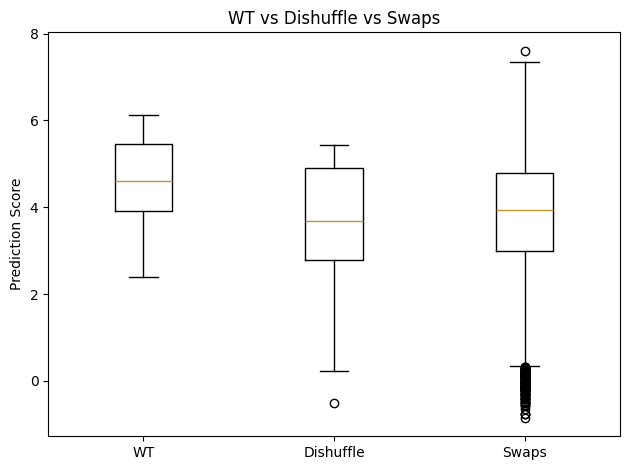

In [163]:
import matplotlib.pyplot as plt

data = [wt_scores, dishuffle_scores, swap_scores_all]
labels = ["WT", "Dishuffle", "Swaps"]

plt.boxplot(data, labels=labels)
plt.ylabel("Prediction Score")
plt.title("WT vs Dishuffle vs Swaps")
plt.tight_layout()
plt.show()
